##### library_check

In [1]:
import subprocess
import sys
import os

def run_cmd(cmd):
    print(f"Running: {cmd}")
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    if result.stdout: print(result.stdout)
    if result.stderr: print(result.stderr)
    return result.returncode == 0

print("🚀 Fixing Transformers Library Corruption...")

# Update pip to the latest version
print("Updating pip...")
run_cmd("python -m pip install --upgrade pip")

# Complete removal of corrupted packages
commands = [
    "pip uninstall -y transformers datasets torch torchvision torchaudio accelerate tokenizers",
    "pip cache purge",
    # Use Windows commands to remove directories
    "rmdir /s /q C:\\Users\\Karthik Sundaram\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\transformers",
    "rmdir /s /q C:\\Users\\Karthik Sundaram\\AppData\\Local\\Programs\Python\\Python312\\Lib\\site-packages\\torch"
]

for cmd in commands:
    run_cmd(cmd)

# Install specific working versions
print("Installing working versions...")
run_cmd("pip install numpy==1.26.4")  # Newer version compatible with Python 3.12
run_cmd("pip install torch==2.3.1+cpu torchvision==0.18.1+cpu -f https://download.pytorch.org/whl/cpu")
run_cmd("pip install transformers==4.44.2")  # Newer, stable version for Python 3.12
run_cmd("pip install datasets==2.21.0 accelerate==0.33.0")  # Updated versions
run_cmd("pip install scikit-learn==1.5.1 matplotlib==3.9.2 seaborn==0.13.2")  # Updated versions

# Verify installation
print("Verifying installation...")
try:
    import torch
    import transformers
    from transformers import BertTokenizer, BertForSequenceClassification
    print("✅ SUCCESS: All libraries working correctly!")
    print(f"PyTorch: {torch.__version__}")
    print(f"Transformers: {transformers.__version__}")
except Exception as e:
    print(f"❌ FAILED: {e}")
    print("Please restart runtime and try again")

🚀 Fixing Transformers Library Corruption...
Updating pip...
Running: python -m pip install --upgrade pip


<>:24: SyntaxWarning: invalid escape sequence '\P'
<>:24: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Karthik Sundaram\AppData\Local\Temp\ipykernel_22852\3994987697.py:24: SyntaxWarning: invalid escape sequence '\P'
  "rmdir /s /q C:\\Users\\Karthik Sundaram\\AppData\\Local\\Programs\Python\\Python312\\Lib\\site-packages\\torch"



Running: pip uninstall -y transformers datasets torch torchvision torchaudio accelerate tokenizers
Found existing installation: transformers 4.44.2
Uninstalling transformers-4.44.2:
  Successfully uninstalled transformers-4.44.2
Found existing installation: tokenizers 0.19.1
Uninstalling tokenizers-0.19.1:
  Successfully uninstalled tokenizers-0.19.1


Running: pip cache purge
Files removed: 16 (12.2 MB)

Running: rmdir /s /q C:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers
The system cannot find the file specified.
The system cannot find the path specified.

Running: rmdir /s /q C:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch
The system cannot find the file specified.
The system cannot find the path specified.

Installing working versions...
Running: pip install numpy==1.26.4

Running: pip install torch==2.3.1+cpu torchvision==0.18.1+cpu -f https://download.pytorch.org/whl/cpu
Looking in links: 

##### BERT

In [ ]:
import os
import subprocess
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import json
import time
import gc
import warnings
warnings.filterwarnings("ignore")

# Disable Weights & Biases
os.environ["WANDB_DISABLED"] = "true"

# Check device (CPU since previous script used torch==2.3.1+cpu)
device = torch.device('cpu')
print(f"Using device: {device}")

# Define base directory for the project
BASE_DIR = r"C:\Users\Karthik Sundaram\Downloads\Abusive_Language_Project"
DATASET_PATH = os.path.join(BASE_DIR, "train.csv")

# Create directories
def create_dirs():
    try:
        os.makedirs(os.path.join(BASE_DIR, "results"), exist_ok=True)
        os.makedirs(os.path.join(BASE_DIR, "models"), exist_ok=True)
    except Exception as e:
        print(f"Error creating directories: {e}")

create_dirs()

def load_and_prepare_data():
    """Load dataset and prepare for training"""
    print("Loading Kaggle Toxic Comment dataset...")
    try:
        # Check if file exists
        if not os.path.exists(DATASET_PATH):
            raise FileNotFoundError(
                f"Dataset file not found at: {DATASET_PATH}\n"
                "Please download 'train.csv' from https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data "
                "and place it in the directory: " + BASE_DIR
            )
        train_df = pd.read_csv(DATASET_PATH)
        print(f"Dataset shape: {train_df.shape}")
        
        # Print columns for debugging
        print("Columns in dataset:", train_df.columns.tolist())
        
        # Verify required columns
        required_columns = ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        missing_columns = [col for col in required_columns if col not in train_df.columns]
        if missing_columns:
            raise KeyError(
                f"Missing required columns: {missing_columns}\n"
                "Expected columns: 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'\n"
                "Ensure you're using the correct 'train.csv' from the Kaggle Toxic Comment Classification Challenge."
            )
        
        # Create binary labels
        toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        train_df['label'] = (train_df[toxicity_columns].sum(axis=1) > 0).astype(int)
        
        # Sample for training
        train_sample = train_df.sample(n=10000, random_state=42)  # Reduced for faster training
        
        # Split data
        train_size = int(0.8 * len(train_sample))
        train_data = train_sample[:train_size]
        val_data = train_sample[train_size:]
        
        print(f"Training samples: {len(train_data)}")
        print(f"Validation samples: {len(val_data)}")
        print(f"Toxic samples: {train_data['label'].sum()}")
        
        return train_data, val_data
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

# Load data
train_data, val_data = load_and_prepare_data()

# Initialize BERT
print("Loading BERT model...")
model_name = 'bert-base-uncased'
try:
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.to(device)
except Exception as e:
    print(f"Error loading BERT model: {e}")
    raise

def tokenize_function(examples):
    return tokenizer(
        examples['comment_text'], 
        truncation=True, 
        padding=True, 
        max_length=256  # Reduced for memory
    )

# Prepare datasets
print("Tokenizing data...")
try:
    train_dataset = Dataset.from_pandas(train_data[['comment_text', 'label']])
    val_dataset = Dataset.from_pandas(val_data[['comment_text', 'label']])
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)
    train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
except Exception as e:
    print(f"Error tokenizing data: {e}")
    raise

# Training arguments
training_args = TrainingArguments(
    output_dir=os.path.join(BASE_DIR, "models", "bert"),
    num_train_epochs=2,  # Reduced for faster training
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=False,  # Disabled since using CPU (from torch==2.3.1+cpu)
    report_to=[],  # Disable wandb
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, average='weighted'),
        'recall': recall_score(labels, predictions, average='weighted'),
        'f1': f1_score(labels, predictions, average='weighted')
    }

# Initialize trainer
try:
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )
except Exception as e:
    print(f"Error initializing trainer: {e}")
    raise

# Training
print("Starting BERT training...")
start_time = time.time()
trainer.train()
training_time = time.time() - start_time

# Evaluation
print("Evaluating BERT model...")
eval_results = trainer.evaluate()
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Create visualizations
plt.figure(figsize=(12, 4))

# Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clean', 'Toxic'], yticklabels=['Clean', 'Toxic'])
plt.title('BERT - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Metrics
plt.subplot(1, 2, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral', 'lightyellow'])
plt.title('BERT - Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
try:
    plt.savefig(os.path.join(BASE_DIR, "results", "bert_results.png"), dpi=300, bbox_inches='tight')
except Exception as e:
    print(f"Error saving visualization: {e}")
plt.show()

# Save results
results = {
    'model': 'BERT',
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1': float(f1),
    'training_time': float(training_time),
    'eval_time': 0
}
try:
    with open(os.path.join(BASE_DIR, "results", "bert_metrics.json"), 'w') as f:
        json.dump(results, f, indent=2)
except Exception as e:
    print(f"Error saving results: {e}")

# Print results
print(f"\n{'='*50}")
print("BERT MODEL RESULTS")
print(f"{'='*50}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Training Time: {training_time:.2f} seconds")

# Save model
try:
    model.save_pretrained(os.path.join(BASE_DIR, "models", "bert_final"))
    tokenizer.save_pretrained(os.path.join(BASE_DIR, "models", "bert_final"))
except Exception as e:
    print(f"Error saving model: {e}")

# Cleanup
del model, trainer
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()

print("\n✅ BERT training completed!")

##### RoBERTa

Using device: cpu
Loading Kaggle Toxic Comment dataset...
Dataset shape: (159571, 8)
Columns in dataset: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Training samples: 8000
Validation samples: 2000
Toxic samples: 799
Loading RoBERTa model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing data...


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Starting RoBERTa training...


  0%|          | 0/2000 [00:00<?, ?it/s]

{'loss': 0.4923, 'grad_norm': 16.64878273010254, 'learning_rate': 2.5e-05, 'epoch': 0.05}
{'loss': 0.3454, 'grad_norm': 2.7195684909820557, 'learning_rate': 5e-05, 'epoch': 0.1}
{'loss': 0.3214, 'grad_norm': 0.8805490136146545, 'learning_rate': 4.868421052631579e-05, 'epoch': 0.15}
{'loss': 0.3599, 'grad_norm': 0.5441291332244873, 'learning_rate': 4.736842105263158e-05, 'epoch': 0.2}
{'loss': 0.2971, 'grad_norm': 0.1484794169664383, 'learning_rate': 4.605263157894737e-05, 'epoch': 0.25}
{'loss': 0.2618, 'grad_norm': 0.3981832265853882, 'learning_rate': 4.473684210526316e-05, 'epoch': 0.3}
{'loss': 0.1844, 'grad_norm': 23.50669288635254, 'learning_rate': 4.342105263157895e-05, 'epoch': 0.35}
{'loss': 0.2783, 'grad_norm': 5.534144401550293, 'learning_rate': 4.210526315789474e-05, 'epoch': 0.4}
{'loss': 0.2899, 'grad_norm': 0.40029996633529663, 'learning_rate': 4.078947368421053e-05, 'epoch': 0.45}
{'loss': 0.3368, 'grad_norm': 41.753395080566406, 'learning_rate': 3.9473684210526316e-05, 

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.2226015329360962, 'eval_accuracy': 0.9485, 'eval_precision': 0.9469232, 'eval_recall': 0.9485, 'eval_f1': 0.9427671196330156, 'eval_runtime': 158.4913, 'eval_samples_per_second': 12.619, 'eval_steps_per_second': 1.577, 'epoch': 1.0}
{'loss': 0.2023, 'grad_norm': 1.2137326002120972, 'learning_rate': 2.5e-05, 'epoch': 1.05}
{'loss': 0.1756, 'grad_norm': 0.3607942759990692, 'learning_rate': 2.368421052631579e-05, 'epoch': 1.1}
{'loss': 0.1453, 'grad_norm': 3.072192668914795, 'learning_rate': 2.236842105263158e-05, 'epoch': 1.15}
{'loss': 0.1122, 'grad_norm': 0.14141780138015747, 'learning_rate': 2.105263157894737e-05, 'epoch': 1.2}
{'loss': 0.1942, 'grad_norm': 2.3551156520843506, 'learning_rate': 1.9736842105263158e-05, 'epoch': 1.25}
{'loss': 0.1297, 'grad_norm': 0.22439120709896088, 'learning_rate': 1.8421052631578947e-05, 'epoch': 1.3}
{'loss': 0.1886, 'grad_norm': 2.2260873317718506, 'learning_rate': 1.7105263157894737e-05, 'epoch': 1.35}
{'loss': 0.1788, 'grad_norm':

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.1621629297733307, 'eval_accuracy': 0.957, 'eval_precision': 0.954915938563414, 'eval_recall': 0.957, 'eval_f1': 0.9549252172469799, 'eval_runtime': 156.6501, 'eval_samples_per_second': 12.767, 'eval_steps_per_second': 1.596, 'epoch': 2.0}
{'train_runtime': 6417.2628, 'train_samples_per_second': 2.493, 'train_steps_per_second': 0.312, 'train_loss': 0.21211556005477905, 'epoch': 2.0}
Evaluating RoBERTa model...


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

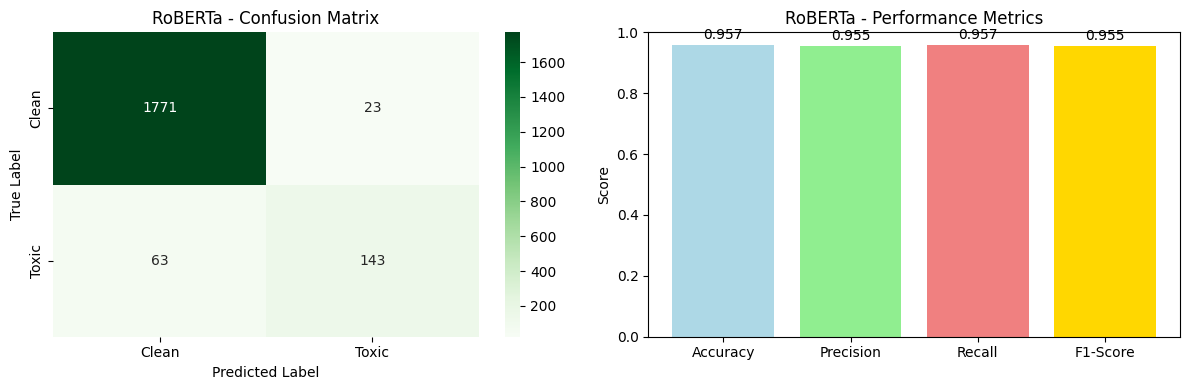


ROBERTA MODEL RESULTS
Accuracy: 0.9570
Precision: 0.9549
Recall: 0.9570
F1-Score: 0.9549
Training Time: 6417.46 seconds

✅ RoBERTa training completed!


In [18]:
import os
import subprocess
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import json
import time
import gc
import warnings
warnings.filterwarnings("ignore")

# Disable Weights & Biases
os.environ["WANDB_DISABLED"] = "true"

# Check device (using CPU for consistency with prior torch==2.3.1+cpu setup)
device = torch.device('cpu')
print(f"Using device: {device}")

# Define base directory for the project
BASE_DIR = r"C:\Users\Karthik Sundaram\Downloads\Abusive_Language_Project"
DATASET_PATH = r"C:\Users\Karthik Sundaram\Downloads\train.csv\train.csv"

# Create directories
def create_dirs():
    try:
        os.makedirs(os.path.join(BASE_DIR, "results"), exist_ok=True)
        os.makedirs(os.path.join(BASE_DIR, "models"), exist_ok=True)
    except Exception as e:
        print(f"Error creating directories: {e}")

create_dirs()

def load_and_prepare_data():
    """Load dataset and prepare for training"""
    print("Loading Kaggle Toxic Comment dataset...")
    try:
        # Check if file exists
        if not os.path.exists(DATASET_PATH):
            raise FileNotFoundError(
                f"Dataset file not found at: {DATASET_PATH}\n"
                "Please download 'train.csv' from https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data "
                "and place it in the directory: C:\\Users\\Karthik Sundaram\\Downloads"
            )
        train_df = pd.read_csv(DATASET_PATH)
        print(f"Dataset shape: {train_df.shape}")
        
        # Print columns for debugging
        print("Columns in dataset:", train_df.columns.tolist())
        
        # Verify required columns
        required_columns = ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        missing_columns = [col for col in required_columns if col not in train_df.columns]
        if missing_columns:
            raise KeyError(
                f"Missing required columns: {missing_columns}\n"
                "Expected columns: 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'\n"
                "Ensure you're using the correct 'train.csv' from the Kaggle Toxic Comment Classification Challenge."
            )
        
        # Create binary labels
        toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        train_df['label'] = (train_df[toxicity_columns].sum(axis=1) > 0).astype(int)
        
        # Sample for training
        train_sample = train_df.sample(n=10000, random_state=42)  # Reduced for faster training
        train_size = int(0.8 * len(train_sample))
        train_data = train_sample[:train_size]
        val_data = train_sample[train_size:]
        
        print(f"Training samples: {len(train_data)}")
        print(f"Validation samples: {len(val_data)}")
        print(f"Toxic samples: {train_data['label'].sum()}")
        
        return train_data, val_data
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

# Load data
train_data, val_data = load_and_prepare_data()

# Initialize RoBERTa
print("Loading RoBERTa model...")
model_name = 'roberta-base'
try:
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.to(device)
except Exception as e:
    print(f"Error loading RoBERTa model: {e}")
    raise

def tokenize_function(examples):
    return tokenizer(
        examples['comment_text'], 
        truncation=True, 
        padding=True, 
        max_length=256  # Reduced for memory
    )

# Prepare datasets
print("Tokenizing data...")
try:
    train_dataset = Dataset.from_pandas(train_data[['comment_text', 'label']])
    val_dataset = Dataset.from_pandas(val_data[['comment_text', 'label']])
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)
    train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
except Exception as e:
    print(f"Error tokenizing data: {e}")
    raise

# Training arguments
training_args = TrainingArguments(
    output_dir=os.path.join(BASE_DIR, "models", "roberta"),
    num_train_epochs=2,  # Reduced for faster training
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=False,  # Disabled since using CPU
    report_to=[],  # Disable wandb
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, average='weighted'),
        'recall': recall_score(labels, predictions, average='weighted'),
        'f1': f1_score(labels, predictions, average='weighted')
    }

# Initialize trainer
try:
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )
except Exception as e:
    print(f"Error initializing trainer: {e}")
    raise

# Training
print("Starting RoBERTa training...")
start_time = time.time()
trainer.train()
training_time = time.time() - start_time

# Evaluation
print("Evaluating RoBERTa model...")
eval_results = trainer.evaluate()
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Create visualizations
plt.figure(figsize=(12, 4))

# Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Clean', 'Toxic'], yticklabels=['Clean', 'Toxic'])
plt.title('RoBERTa - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Metrics
plt.subplot(1, 2, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
bars = plt.bar(metrics, values, color=['lightblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title('RoBERTa - Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
try:
    plt.savefig(os.path.join(BASE_DIR, "results", "roberta_results.png"), dpi=300, bbox_inches='tight')
except Exception as e:
    print(f"Error saving visualization: {e}")
plt.show()

# Save results
results = {
    'model': 'RoBERTa',
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1': float(f1),
    'training_time': float(training_time),
    'eval_time': 0
}
try:
    with open(os.path.join(BASE_DIR, "results", "roberta_metrics.json"), 'w') as f:
        json.dump(results, f, indent=2)
except Exception as e:
    print(f"Error saving results: {e}")

# Print results
print(f"\n{'='*50}")
print("ROBERTA MODEL RESULTS")
print(f"{'='*50}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Training Time: {training_time:.2f} seconds")

# Save model
try:
    model.save_pretrained(os.path.join(BASE_DIR, "models", "roberta_final"))
    tokenizer.save_pretrained(os.path.join(BASE_DIR, "models", "roberta_final"))
except Exception as e:
    print(f"Error saving model: {e}")

# Cleanup
del model, trainer
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()

print("\n✅ RoBERTa training completed!")

##### DistilBERT

Using device: cpu
Loading Kaggle Toxic Comment dataset...
Dataset shape: (159571, 8)
Columns in dataset: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Training samples: 8000
Validation samples: 2000
Toxic samples: 799
Loading DistilBERT model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing data...


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Starting DistilBERT training...


  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 0.484, 'grad_norm': 1.374232292175293, 'learning_rate': 2.5e-05, 'epoch': 0.1}
{'loss': 0.1824, 'grad_norm': 0.24523445963859558, 'learning_rate': 5e-05, 'epoch': 0.2}
{'loss': 0.1681, 'grad_norm': 4.144676208496094, 'learning_rate': 4.722222222222222e-05, 'epoch': 0.3}
{'loss': 0.1753, 'grad_norm': 6.223335266113281, 'learning_rate': 4.4444444444444447e-05, 'epoch': 0.4}
{'loss': 0.174, 'grad_norm': 6.513287544250488, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.5}
{'loss': 0.1399, 'grad_norm': 2.6009292602539062, 'learning_rate': 3.888888888888889e-05, 'epoch': 0.6}
{'loss': 0.0928, 'grad_norm': 4.833001613616943, 'learning_rate': 3.611111111111111e-05, 'epoch': 0.7}
{'loss': 0.1133, 'grad_norm': 1.851247787475586, 'learning_rate': 3.3333333333333335e-05, 'epoch': 0.8}
{'loss': 0.1336, 'grad_norm': 3.927863359451294, 'learning_rate': 3.055555555555556e-05, 'epoch': 0.9}
{'loss': 0.1463, 'grad_norm': 3.412907838821411, 'learning_rate': 2.777777777777778e-05, 'epoch': 1.

  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.10314564406871796, 'eval_accuracy': 0.9595, 'eval_precision': 0.9597687720901157, 'eval_recall': 0.9595, 'eval_f1': 0.9596294399354741, 'eval_runtime': 72.4809, 'eval_samples_per_second': 27.593, 'eval_steps_per_second': 1.725, 'epoch': 1.0}
{'loss': 0.0479, 'grad_norm': 1.4174189567565918, 'learning_rate': 2.5e-05, 'epoch': 1.1}
{'loss': 0.0654, 'grad_norm': 0.025002021342515945, 'learning_rate': 2.2222222222222223e-05, 'epoch': 1.2}
{'loss': 0.0722, 'grad_norm': 0.11172022670507431, 'learning_rate': 1.9444444444444445e-05, 'epoch': 1.3}
{'loss': 0.0703, 'grad_norm': 0.1568046510219574, 'learning_rate': 1.6666666666666667e-05, 'epoch': 1.4}
{'loss': 0.0749, 'grad_norm': 8.485509872436523, 'learning_rate': 1.388888888888889e-05, 'epoch': 1.5}
{'loss': 0.0623, 'grad_norm': 0.16839918494224548, 'learning_rate': 1.1111111111111112e-05, 'epoch': 1.6}
{'loss': 0.043, 'grad_norm': 0.1539643406867981, 'learning_rate': 8.333333333333334e-06, 'epoch': 1.7}
{'loss': 0.0591, 'grad

  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.12302103638648987, 'eval_accuracy': 0.967, 'eval_precision': 0.9662945165599206, 'eval_recall': 0.967, 'eval_f1': 0.9665600000000001, 'eval_runtime': 72.1686, 'eval_samples_per_second': 27.713, 'eval_steps_per_second': 1.732, 'epoch': 2.0}
{'train_runtime': 3011.2805, 'train_samples_per_second': 5.313, 'train_steps_per_second': 0.332, 'train_loss': 0.12176515650749206, 'epoch': 2.0}
Evaluating DistilBERT model...


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

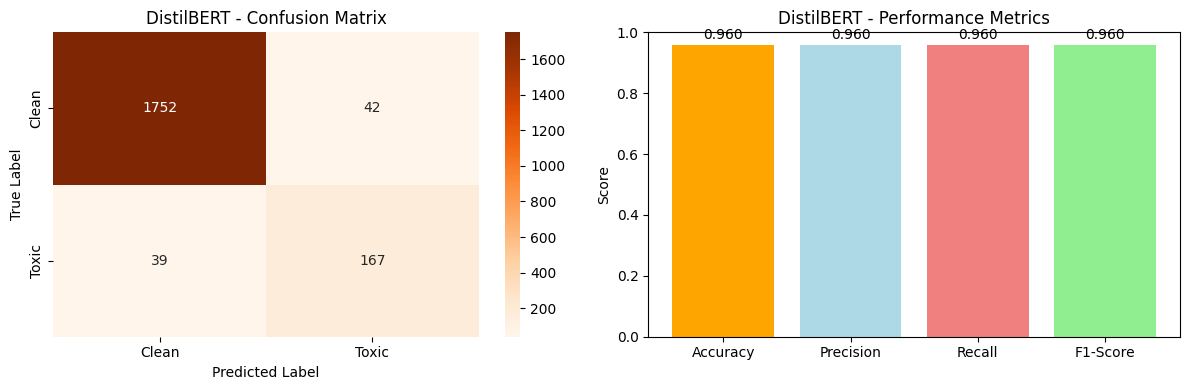


DISTILBERT MODEL RESULTS
Accuracy: 0.9595
Precision: 0.9598
Recall: 0.9595
F1-Score: 0.9596
Training Time: 3011.49 seconds

✅ DistilBERT training completed!


In [21]:
import os
import subprocess
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import json
import time
import gc
import warnings
warnings.filterwarnings("ignore")

# Disable Weights & Biases
os.environ["WANDB_DISABLED"] = "true"

# Check device (using CPU for consistency with prior torch==2.3.1+cpu setup)
device = torch.device('cpu')
print(f"Using device: {device}")

# Define base directory for the project
BASE_DIR = r"C:\Users\Karthik Sundaram\Downloads\Abusive_Language_Project"
DATASET_PATH = r"C:\Users\Karthik Sundaram\Downloads\train.csv\train.csv"

# Create directories
def create_dirs():
    try:
        os.makedirs(os.path.join(BASE_DIR, "results"), exist_ok=True)
        os.makedirs(os.path.join(BASE_DIR, "models"), exist_ok=True)
    except Exception as e:
        print(f"Error creating directories: {e}")

create_dirs()

def load_and_prepare_data():
    """Load dataset and prepare for training"""
    print("Loading Kaggle Toxic Comment dataset...")
    try:
        # Check if file exists
        if not os.path.exists(DATASET_PATH):
            raise FileNotFoundError(
                f"Dataset file not found at: {DATASET_PATH}\n"
                "Please download 'train.csv' from https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data "
                "and place it in the directory: C:\\Users\\Karthik Sundaram\\Downloads"
            )
        train_df = pd.read_csv(DATASET_PATH)
        print(f"Dataset shape: {train_df.shape}")
        
        # Print columns for debugging
        print("Columns in dataset:", train_df.columns.tolist())
        
        # Verify required columns
        required_columns = ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        missing_columns = [col for col in required_columns if col not in train_df.columns]
        if missing_columns:
            raise KeyError(
                f"Missing required columns: {missing_columns}\n"
                "Expected columns: 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'\n"
                "Ensure you're using the correct 'train.csv' from the Kaggle Toxic Comment Classification Challenge."
            )
        
        # Create binary labels
        toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        train_df['label'] = (train_df[toxicity_columns].sum(axis=1) > 0).astype(int)
        
        # Sample for training
        train_sample = train_df.sample(n=10000, random_state=42)  # Reduced for faster training
        train_size = int(0.8 * len(train_sample))
        train_data = train_sample[:train_size]
        val_data = train_sample[train_size:]
        
        print(f"Training samples: {len(train_data)}")
        print(f"Validation samples: {len(val_data)}")
        print(f"Toxic samples: {train_data['label'].sum()}")
        
        return train_data, val_data
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

# Load data
train_data, val_data = load_and_prepare_data()

# Initialize DistilBERT
print("Loading DistilBERT model...")
model_name = 'distilbert-base-uncased'
try:
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.to(device)
except Exception as e:
    print(f"Error loading DistilBERT model: {e}")
    raise

def tokenize_function(examples):
    return tokenizer(
        examples['comment_text'], 
        truncation=True, 
        padding=True, 
        max_length=256  # Reduced for memory
    )

# Prepare datasets
print("Tokenizing data...")
try:
    train_dataset = Dataset.from_pandas(train_data[['comment_text', 'label']])
    val_dataset = Dataset.from_pandas(val_data[['comment_text', 'label']])
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)
    train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
except Exception as e:
    print(f"Error tokenizing data: {e}")
    raise

# Training arguments
training_args = TrainingArguments(
    output_dir=os.path.join(BASE_DIR, "models", "distilbert"),
    num_train_epochs=2,  # Reduced for faster training
    per_device_train_batch_size=16,  # DistilBERT can handle larger batches
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=False,  # Disabled since using CPU
    report_to=[],  # Disable wandb
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, average='weighted'),
        'recall': recall_score(labels, predictions, average='weighted'),
        'f1': f1_score(labels, predictions, average='weighted')
    }

# Initialize trainer
try:
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )
except Exception as e:
    print(f"Error initializing trainer: {e}")
    raise

# Training
print("Starting DistilBERT training...")
start_time = time.time()
trainer.train()
training_time = time.time() - start_time

# Evaluation
print("Evaluating DistilBERT model...")
eval_results = trainer.evaluate()
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Create visualizations
plt.figure(figsize=(12, 4))

# Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Clean', 'Toxic'], yticklabels=['Clean', 'Toxic'])
plt.title('DistilBERT - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Metrics
plt.subplot(1, 2, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
bars = plt.bar(metrics, values, color=['orange', 'lightblue', 'lightcoral', 'lightgreen'])
plt.title('DistilBERT - Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
try:
    plt.savefig(os.path.join(BASE_DIR, "results", "distilbert_results.png"), dpi=300, bbox_inches='tight')
except Exception as e:
    print(f"Error saving visualization: {e}")
plt.show()

# Save results
results = {
    'model': 'DistilBERT',
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1': float(f1),
    'training_time': float(training_time),
    'eval_time': 0
}
try:
    with open(os.path.join(BASE_DIR, "results", "distilbert_metrics.json"), 'w') as f:
        json.dump(results, f, indent=2)
except Exception as e:
    print(f"Error saving results: {e}")

# Print results
print(f"\n{'='*50}")
print("DISTILBERT MODEL RESULTS")
print(f"{'='*50}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Training Time: {training_time:.2f} seconds")

# Save model
try:
    model.save_pretrained(os.path.join(BASE_DIR, "models", "distilbert_final"))
    tokenizer.save_pretrained(os.path.join(BASE_DIR, "models", "distilbert_final"))
except Exception as e:
    print(f"Error saving model: {e}")

# Cleanup
del model, trainer
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()

print("\n✅ DistilBERT training completed!")

##### Detoxify

In [23]:
pip install detoxify

Note: you may need to restart the kernel to use updated packages.


Loading Kaggle Toxic Comment dataset...
Dataset shape: (159571, 8)
Columns in dataset: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Test samples: 2000
Toxic samples: 201
Loading Detoxify model...
Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.1-alpha/toxic_original-c1212f89.ckpt" to C:\Users\Karthik Sundaram/.cache\torch\hub\checkpoints\toxic_original-c1212f89.ckpt


100%|██████████| 418M/418M [00:17<00:00, 25.6MB/s] 


Evaluating Detoxify model...


100%|██████████| 2000/2000 [01:40<00:00, 19.89it/s]


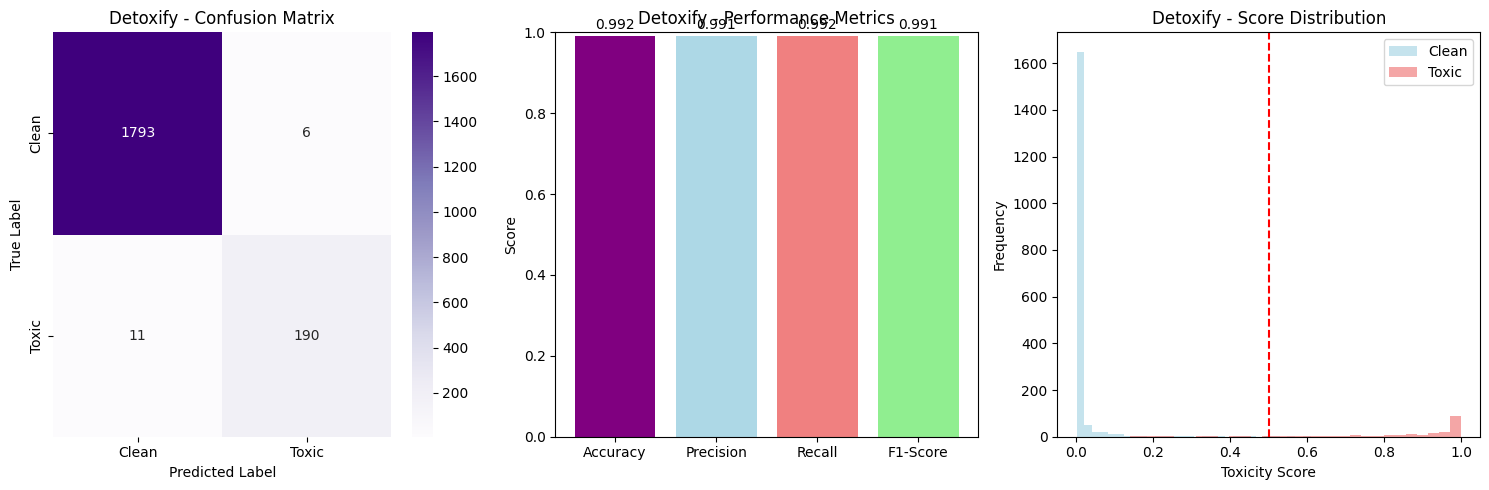


DETOXIFY MODEL RESULTS
Accuracy: 0.9915
Precision: 0.9914
Recall: 0.9915
F1-Score: 0.9915
Evaluation Time: 100.53 seconds

✅ Detoxify evaluation completed!


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from detoxify import Detoxify
import json
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Define base directory for the project
BASE_DIR = r"C:\Users\Karthik Sundaram\Downloads\Abusive_Language_Project"
DATASET_PATH = r"C:\Users\Karthik Sundaram\Downloads\train.csv\train.csv"

# Create directories
def create_dirs():
    try:
        os.makedirs(os.path.join(BASE_DIR, "results"), exist_ok=True)
    except Exception as e:
        print(f"Error creating directories: {e}")

create_dirs()

def load_and_prepare_data():
    """Load dataset and prepare for evaluation"""
    print("Loading Kaggle Toxic Comment dataset...")
    try:
        # Check if file exists
        if not os.path.exists(DATASET_PATH):
            raise FileNotFoundError(
                f"Dataset file not found at: {DATASET_PATH}\n"
                "Please download 'train.csv' from https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data "
                "and place it in the directory: C:\\Users\\Karthik Sundaram\\Downloads"
            )
        train_df = pd.read_csv(DATASET_PATH)
        print(f"Dataset shape: {train_df.shape}")
        
        # Print columns for debugging
        print("Columns in dataset:", train_df.columns.tolist())
        
        # Verify required columns
        required_columns = ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        missing_columns = [col for col in required_columns if col not in train_df.columns]
        if missing_columns:
            raise KeyError(
                f"Missing required columns: {missing_columns}\n"
                "Expected columns: 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'\n"
                "Ensure you're using the correct 'train.csv' from the Kaggle Toxic Comment Classification Challenge."
            )
        
        # Create binary labels
        toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        train_df['label'] = (train_df[toxicity_columns].sum(axis=1) > 0).astype(int)
        
        # Sample for evaluation
        test_sample = train_df.sample(n=2000, random_state=42)  # Smaller for Detoxify
        print(f"Test samples: {len(test_sample)}")
        print(f"Toxic samples: {test_sample['label'].sum()}")
        
        return test_sample
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

# Load data
test_data = load_and_prepare_data()

# Initialize Detoxify
print("Loading Detoxify model...")
try:
    detoxify_model = Detoxify('original')
except Exception as e:
    print(f"Error loading Detoxify model: {e}")
    raise

def evaluate_detoxify(data, threshold=0.5):
    """Evaluate the Detoxify model on the dataset"""
    texts = data['comment_text'].tolist()
    true_labels = data['label'].tolist()
    
    predictions = []
    prediction_scores = []
    
    print("Evaluating Detoxify model...")
    start_time = time.time()
    
    for text in tqdm(texts[:2000]):  # Limit for faster processing
        try:
            result = detoxify_model.predict(text)
            toxicity_score = result['toxicity']
            prediction = 1 if toxicity_score >= threshold else 0
            predictions.append(prediction)
            prediction_scores.append(toxicity_score)
        except Exception as e:
            print(f"Error processing text: {e}")
            predictions.append(0)
            prediction_scores.append(0.0)
    
    eval_time = time.time() - start_time
    return predictions, prediction_scores, true_labels[:len(predictions)], eval_time

# Evaluate model
y_pred, pred_scores, y_true, eval_time = evaluate_detoxify(test_data)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Create visualizations
plt.figure(figsize=(15, 5))

# Confusion Matrix
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Clean', 'Toxic'], yticklabels=['Clean', 'Toxic'])
plt.title('Detoxify - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Metrics
plt.subplot(1, 3, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
bars = plt.bar(metrics, values, color=['purple', 'lightblue', 'lightcoral', 'lightgreen'])
plt.title('Detoxify - Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom')

# Score Distribution
plt.subplot(1, 3, 3)
plt.hist([score for i, score in enumerate(pred_scores) if y_true[i] == 0], alpha=0.7, label='Clean', bins=30, color='lightblue')
plt.hist([score for i, score in enumerate(pred_scores) if y_true[i] == 1], alpha=0.7, label='Toxic', bins=30, color='lightcoral')
plt.xlabel('Toxicity Score')
plt.ylabel('Frequency')
plt.title('Detoxify - Score Distribution')
plt.legend()
plt.axvline(x=0.5, color='red', linestyle='--')

plt.tight_layout()
try:
    plt.savefig(os.path.join(BASE_DIR, "results", "detoxify_results.png"), dpi=300, bbox_inches='tight')
except Exception as e:
    print(f"Error saving visualization: {e}")
plt.show()

# Save results
results = {
    'model': 'Detoxify',
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1': float(f1),
    'training_time': 0,
    'eval_time': float(eval_time)
}
try:
    with open(os.path.join(BASE_DIR, "results", "detoxify_metrics.json"), 'w') as f:
        json.dump(results, f, indent=2)
except Exception as e:
    print(f"Error saving results: {e}")

# Print results
print(f"\n{'='*50}")
print("DETOXIFY MODEL RESULTS")
print(f"{'='*50}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Evaluation Time: {eval_time:.2f} seconds")

print("\n✅ Detoxify evaluation completed!")

##### SVM

In [3]:
pip install nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 26.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Created/Verified directories: C:\Users\Karthik Sundaram\Downloads\Abusive_Language_Project\results, C:\Users\Karthik Sundaram\Downloads\Abusive_Language_Project\models
Loading Kaggle Toxic Comment dataset...
Dataset shape: (159571, 8)

Comment text stats:
- Total rows: 159571
- NaN values: 0
- Empty strings: 0
- Non-string types: 0

Sample comment_text (first 3):
0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
Rows after removing NaN comment_text: 159571

Sample size: 10000
Toxic samples: 1005
Clean samples: 8995

Preprocessing text...

Preprocessing results:
- Total texts: 10000
- Empty processed texts: 2
- Short processed texts (≤2 chars): 3

Sample processed texts (first 5):
Original: 'Geez, are you forgetful!  We've already discussed why Marx  was  not an anarchist, i.e. he wanted to...'
Processed: 'geez forget alreadi discuss marx not anarchist want use state mold s

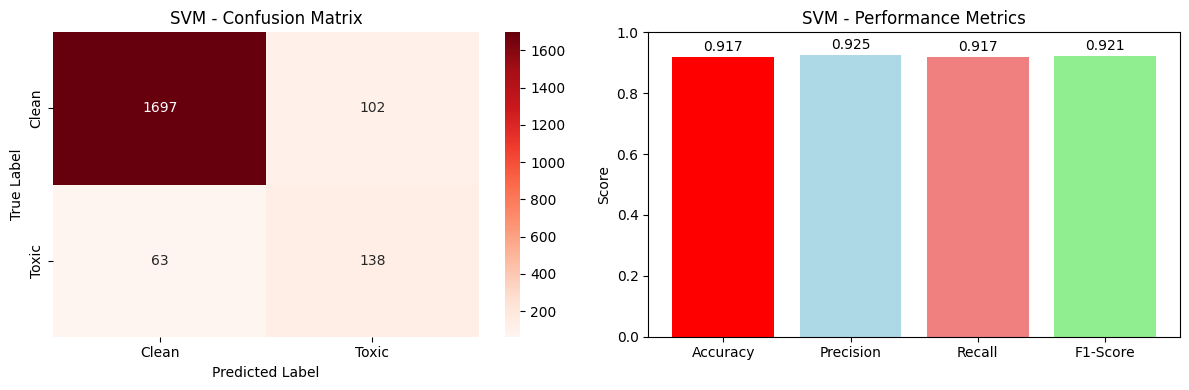

Results saved successfully!
Model and vectorizer saved successfully!

TESTING WITH SAMPLE TEXTS
Text: 'You are a wonderful person!'
Processed: 'wonder person...'
Prediction: Clean (Probability: 0.083)
--------------------------------------------------
Text: 'I hate you so much'
Processed: 'hate much...'
Prediction: Toxic (Probability: 0.585)
--------------------------------------------------
Text: 'This is a normal comment'
Processed: 'normal comment...'
Prediction: Clean (Probability: 0.032)
--------------------------------------------------
Text: 'What a stupid idiot'
Processed: 'stupid idiot...'
Prediction: Toxic (Probability: 1.000)
--------------------------------------------------

✅ SVM training completed!


In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
import json
import time
import pickle
import gc
import warnings
warnings.filterwarnings("ignore")

# Download NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
except Exception as e:
    print(f"Error downloading NLTK data: {e}")
    raise

# Define base directory for the project
BASE_DIR = r"C:\Users\Karthik Sundaram\Downloads\Abusive_Language_Project"
DATASET_PATH = r"C:\Users\Karthik Sundaram\Downloads\train.csv\train.csv"

# Create directories with verification
def create_dirs():
    try:
        results_dir = os.path.join(BASE_DIR, "results")
        models_dir = os.path.join(BASE_DIR, "models")
        os.makedirs(results_dir, exist_ok=True)
        os.makedirs(models_dir, exist_ok=True)
        if not os.path.exists(results_dir) or not os.path.exists(models_dir):
            raise OSError(f"Failed to create directories: {results_dir}, {models_dir}")
        print(f"Created/Verified directories: {results_dir}, {models_dir}")
    except Exception as e:
        print(f"Error creating directories at {BASE_DIR}: {e}")
        raise

create_dirs()

def preprocess_text(text):
    """Improved text preprocessing for SVM"""
    try:
        # Handle non-string or NaN inputs
        if not isinstance(text, str) or pd.isna(text):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs, mentions, hashtags
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+|#\w+', '', text)
        
        # Keep alphanumeric characters and spaces
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        # If text is too short, return as is
        if len(text.split()) <= 2:
            return text
        
        # Tokenize
        try:
            tokens = word_tokenize(text)
        except:
            tokens = text.split()
        
        # Remove stopwords, preserving important words
        stop_words = set(stopwords.words('english')) - {'not', 'no', 'never', 'nothing', 'nobody', 'neither', 'nowhere', 'none'}
        tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
        
        # Apply stemming if tokens remain
        if tokens:
            stemmer = PorterStemmer()
            tokens = [stemmer.stem(t) for t in tokens]
        
        processed = ' '.join(tokens)
        return processed if processed.strip() else ""
    except Exception as e:
        print(f"Error processing text '{text[:50]}...': {e}")
        return text.lower() if isinstance(text, str) else ""

def load_and_prepare_data():
    """Load dataset and prepare for training"""
    print("Loading Kaggle Toxic Comment dataset...")
    try:
        # Verify dataset path
        if not os.path.exists(DATASET_PATH):
            raise FileNotFoundError(
                f"Dataset file not found at: {DATASET_PATH}\n"
                "Please download 'train.csv' from https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data "
                "and place it in: C:\\Users\\Karthik Sundaram\\Downloads\\train.csv"
            )
        
        train_df = pd.read_csv(DATASET_PATH)
        print(f"Dataset shape: {train_df.shape}")
        
        # Debug comment_text column
        print("\nComment text stats:")
        print(f"- Total rows: {len(train_df)}")
        print(f"- NaN values: {train_df['comment_text'].isna().sum()}")
        print(f"- Empty strings: {(train_df['comment_text'] == '').sum()}")
        print(f"- Non-string types: {train_df['comment_text'].apply(lambda x: not isinstance(x, str)).sum()}")
        print("\nSample comment_text (first 3):")
        print(train_df['comment_text'].head(3).to_string())
        
        # Verify required columns
        required_columns = ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        missing_columns = [col for col in required_columns if col not in train_df.columns]
        if missing_columns:
            raise KeyError(f"Missing columns: {missing_columns}")
        
        # Remove rows with NaN comment_text
        train_df = train_df.dropna(subset=['comment_text'])
        print(f"Rows after removing NaN comment_text: {len(train_df)}")
        
        # Create binary labels
        toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        train_df['label'] = (train_df[toxicity_columns].sum(axis=1) > 0).astype(int)
        
        # Sample for training
        sample_size = min(10000, len(train_df))
        train_sample = train_df.sample(n=sample_size, random_state=42)
        print(f"\nSample size: {len(train_sample)}")
        print(f"Toxic samples: {train_sample['label'].sum()}")
        print(f"Clean samples: {len(train_sample) - train_sample['label'].sum()}")
        
        return train_sample
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

# Load data
data = load_and_prepare_data()

# Preprocess text
print("\nPreprocessing text...")
try:
    data['processed_text'] = data['comment_text'].apply(preprocess_text)
    
    # Debug preprocessing
    print("\nPreprocessing results:")
    print(f"- Total texts: {len(data)}")
    print(f"- Empty processed texts: {(data['processed_text'] == '').sum()}")
    print(f"- Short processed texts (≤2 chars): {(data['processed_text'].str.len() <= 2).sum()}")
    print("\nSample processed texts (first 5):")
    for i in range(min(5, len(data))):
        print(f"Original: '{data.iloc[i]['comment_text'][:100]}...'")
        print(f"Processed: '{data.iloc[i]['processed_text'][:100]}...'")
        print("-" * 50)
    
    # Filter valid texts
    original_len = len(data)
    data = data[data['processed_text'].str.len() > 2]
    print(f"Filtered data: {original_len} -> {len(data)} samples")
    
    if data.empty:
        raise ValueError(
            "No valid data remains after preprocessing. Possible causes:\n"
            "1. All comment_text entries are NaN, empty, or non-string.\n"
            "2. Dataset is corrupted or incorrect.\n"
            "3. Preprocessing is too aggressive.\n"
            "Check the dataset at: " + DATASET_PATH
        )
    print(f"Valid samples after preprocessing: {len(data)}")
except Exception as e:
    print(f"Error preprocessing data: {e}")
    raise

# Prepare features and labels
X = data['processed_text']
y = data['label']

# Check dataset size
if len(X) < 10:
    raise ValueError(f"Dataset too small: {len(X)} samples. Need at least 10 samples.")

# Split data
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"\nTraining samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"Training toxic ratio: {y_train.sum() / len(y_train):.3f}")
    print(f"Test toxic ratio: {y_test.sum() / len(y_test):.3f}")
except Exception as e:
    print(f"Error splitting data: {e}")
    raise

# Extract TF-IDF features
print("\nExtracting TF-IDF features...")
try:
    vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2), min_df=2, max_df=0.95)
    start_time = time.time()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    feature_time = time.time() - start_time
    print(f"Feature extraction time: {feature_time:.2f} seconds")
except Exception as e:
    print(f"Error extracting TF-IDF features: {e}")
    raise

# Train SVM
print("\nTraining SVM...")
try:
    svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True, class_weight='balanced')
    start_time = time.time()
    svm_model.fit(X_train_tfidf, y_train)
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")
except Exception as e:
    print(f"Error training SVM: {e}")
    raise

# Predict
print("\nMaking predictions...")
try:
    start_time = time.time()
    y_pred = svm_model.predict(X_test_tfidf)
    y_pred_proba = svm_model.predict_proba(X_test_tfidf)[:, 1]
    eval_time = time.time() - start_time
    print(f"Prediction time: {eval_time:.2f} seconds")
except Exception as e:
    print(f"Error making predictions: {e}")
    raise

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Create visualizations
plt.figure(figsize=(12, 4))

# Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Clean', 'Toxic'], yticklabels=['Clean', 'Toxic'])
plt.title('SVM - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Metrics
plt.subplot(1, 2, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
bars = plt.bar(metrics, values, color=['red', 'lightblue', 'lightcoral', 'lightgreen'])
plt.title('SVM - Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
try:
    plt.savefig(os.path.join(BASE_DIR, "results", "svm_results.png"), dpi=300, bbox_inches='tight')
    print("Visualization saved successfully!")
except Exception as e:
    print(f"Error saving visualization: {e}")
plt.show()

# Save results
results = {
    'model': 'SVM',
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1': float(f1),
    'training_time': float(training_time),
    'feature_extraction_time': float(feature_time),
    'eval_time': float(eval_time),
    'samples_used': len(X),
    'toxic_samples': int(y.sum()),
    'clean_samples': int(len(y) - y.sum()),
    'toxic_ratio': float(y.sum() / len(y))
}
try:
    with open(os.path.join(BASE_DIR, "results", "svm_metrics.json"), 'w') as f:
        json.dump(results, f, indent=2)
    print("Results saved successfully!")
except Exception as e:
    print(f"Error saving results: {e}")

# Save model and vectorizer
try:
    with open(os.path.join(BASE_DIR, "models", "svm_model.pkl"), 'wb') as f:
        pickle.dump(svm_model, f)
    with open(os.path.join(BASE_DIR, "models", "tfidf_vectorizer.pkl"), 'wb') as f:
        pickle.dump(vectorizer, f)
    print("Model and vectorizer saved successfully!")
except Exception as e:
    print(f"Error saving model or vectorizer: {e}")

# Test with sample texts
print(f"\n{'='*50}")
print("TESTING WITH SAMPLE TEXTS")
print(f"{'='*50}")
test_texts = [
    "You are a wonderful person!",
    "I hate you so much",
    "This is a normal comment",
    "What a stupid idiot"
]
for text in test_texts:
    processed = preprocess_text(text)
    if processed:
        text_tfidf = vectorizer.transform([processed])
        prediction = svm_model.predict(text_tfidf)[0]
        probability = svm_model.predict_proba(text_tfidf)[0][1]
        label = "Toxic" if prediction == 1 else "Clean"
        print(f"Text: '{text}'")
        print(f"Processed: '{processed[:100]}...'")
        print(f"Prediction: {label} (Probability: {probability:.3f})")
        print("-" * 50)

# Cleanup
del svm_model, vectorizer, X_train_tfidf, X_test_tfidf
gc.collect()

print("\n✅ SVM training completed!")

##### model_comparison

✓ Loaded BERT results
✓ Loaded ROBERTA results
✓ Loaded DISTILBERT results
✓ Loaded DETOXIFY results
✓ Loaded SVM results

MODEL COMPARISON RESULTS
        Model  Accuracy  Precision  Recall  F1-Score  Training_Time  Eval_Time
0        BERT    0.9575     0.9563  0.9575    0.9568      6328.1125     0.0000
1     ROBERTA    0.9570     0.9549  0.9570    0.9549      6417.4631     0.0000
2  DISTILBERT    0.9595     0.9598  0.9595    0.9596      3011.4909     0.0000
3    DETOXIFY    0.9915     0.9914  0.9915    0.9915         0.0000   100.5343
4         SVM    0.9175     0.9251  0.9175    0.9207        11.6531     0.9748
✓ Saved comparison table to: C:\Users\Karthik Sundaram\Downloads\Abusive_Language_Project\results\model_comparison.csv
✓ Saved visualization to: C:\Users\Karthik Sundaram\Downloads\Abusive_Language_Project\results\comprehensive_comparison.png


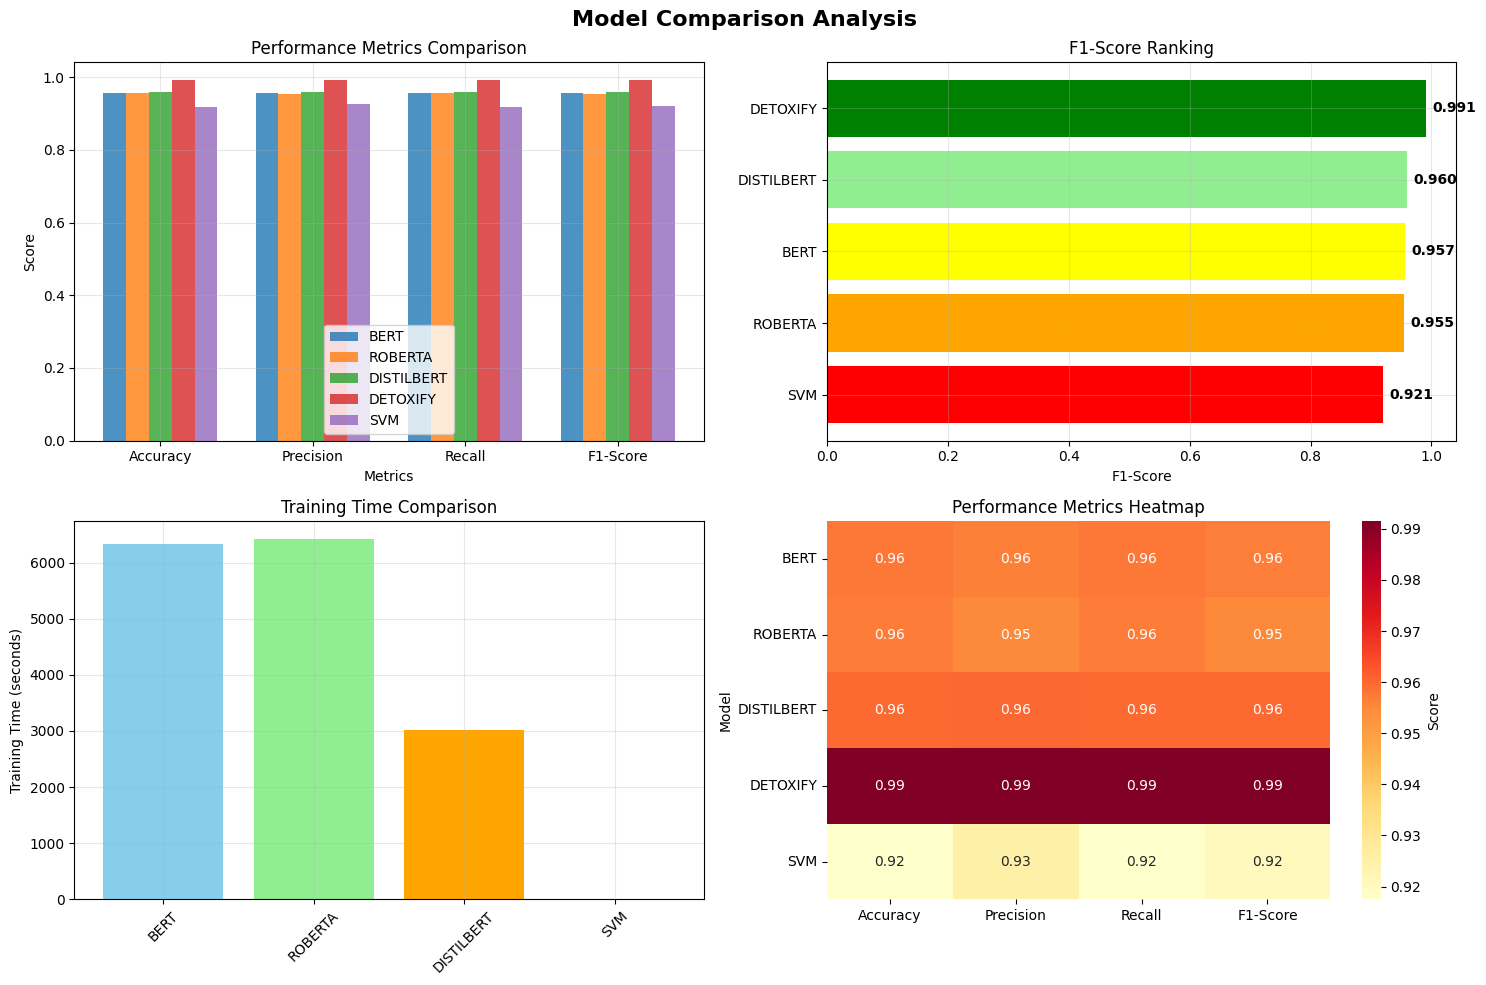


STATISTICAL ANALYSIS
🏆 Best Overall Model: DETOXIFY
   F1-Score: 0.9915
   Accuracy: 0.9915

⚡ Fastest Model: BERT
   Evaluation Time: 0.00 seconds
   F1-Score: 0.9568
✓ Saved analysis summary to: C:\Users\Karthik Sundaram\Downloads\Abusive_Language_Project\results\analysis_summary.json

✅ Model comparison completed!
📁 Results saved to: C:\Users\Karthik Sundaram\Downloads\Abusive_Language_Project\results


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
warnings.filterwarnings("ignore")

# Define results directory
RESULTS_DIR = r"C:\Users\Karthik Sundaram\Downloads\Abusive_Language_Project\results"

# Verify results directory
if not os.path.exists(RESULTS_DIR):
    raise FileNotFoundError(
        f"Results directory not found at: {RESULTS_DIR}\n"
        "Ensure JSON files are in this directory."
    )

def load_all_results():
    """Load JSON results for all models"""
    models = ['bert', 'roberta', 'distilbert', 'detoxify', 'svm']
    all_results = {}
    
    for model in models:
        file_path = os.path.join(RESULTS_DIR, f'{model}_metrics.json')
        try:
            if os.path.exists(file_path):
                with open(file_path, 'r') as f:
                    all_results[model] = json.load(f)
                print(f"✓ Loaded {model.upper()} results")
            else:
                raise FileNotFoundError(f"{model}_metrics.json not found")
        except Exception as e:
            print(f"✗ Error loading {model.upper()} results: {e}")
    
    if not all_results:
        raise ValueError("No model results loaded. Check JSON files in results directory.")
    
    return all_results

# Load results
results = load_all_results()

# Create comparison DataFrame
comparison_data = []
for model_name, model_results in results.items():
    try:
        comparison_data.append([
            model_name.upper(),
            model_results['accuracy'],
            model_results['precision'],
            model_results['recall'],
            model_results['f1'],
            model_results.get('training_time', 0),
            model_results.get('eval_time', 0)
        ])
    except KeyError as e:
        print(f"Error processing {model_name.upper()}: Missing key {e}")
        continue

df_comparison = pd.DataFrame(comparison_data, columns=[
    'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 
    'Training_Time', 'Eval_Time'
])

# Display comparison table
print(f"\n{'='*80}")
print("MODEL COMPARISON RESULTS")
print(f"{'='*80}")
print(df_comparison.round(4))

# Save comparison to CSV
try:
    csv_path = os.path.join(RESULTS_DIR, 'model_comparison.csv')
    df_comparison.to_csv(csv_path, index=False)
    print(f"✓ Saved comparison table to: {csv_path}")
except Exception as e:
    print(f"Error saving model_comparison.csv: {e}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Comparison Analysis', fontsize=16, fontweight='bold')

# Performance metrics comparison
ax1 = axes[0, 0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.15

for i, model in enumerate(df_comparison['Model']):
    values = [df_comparison.iloc[i][metric] for metric in metrics]
    ax1.bar(x + i*width, values, width, label=model, alpha=0.8)

ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.set_title('Performance Metrics Comparison')
ax1.set_xticks(x + width*2)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(True, alpha=0.3)

# F1-Score ranking
ax2 = axes[0, 1]
df_sorted = df_comparison.sort_values('F1-Score', ascending=True)
bars = ax2.barh(df_sorted['Model'], df_sorted['F1-Score'], color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
ax2.set_xlabel('F1-Score')
ax2.set_title('F1-Score Ranking')
ax2.grid(True, alpha=0.3)

for i, (bar, value) in enumerate(zip(bars, df_sorted['F1-Score'])):
    ax2.text(value + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
             va='center', fontweight='bold')

# Training time comparison
ax3 = axes[1, 0]
training_times = df_comparison[df_comparison['Training_Time'] > 0]
bars = ax3.bar(training_times['Model'], training_times['Training_Time'], 
               color=['skyblue', 'lightgreen', 'orange', 'lightcoral'])
ax3.set_ylabel('Training Time (seconds)')
ax3.set_title('Training Time Comparison')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# Performance heatmap
ax4 = axes[1, 1]
heatmap_data = df_comparison.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'Score'})
ax4.set_title('Performance Metrics Heatmap')

plt.tight_layout()
try:
    plt_path = os.path.join(RESULTS_DIR, 'comprehensive_comparison.png')
    plt.savefig(plt_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved visualization to: {plt_path}")
except Exception as e:
    print(f"Error saving comprehensive_comparison.png: {e}")
plt.show()

# Statistical analysis
try:
    best_model = df_comparison.loc[df_comparison['F1-Score'].idxmax()]
    fastest_model = df_comparison.loc[df_comparison['Eval_Time'].idxmin()]

    print(f"\n{'='*60}")
    print("STATISTICAL ANALYSIS")
    print(f"{'='*60}")
    print(f"🏆 Best Overall Model: {best_model['Model']}")
    print(f"   F1-Score: {best_model['F1-Score']:.4f}")
    print(f"   Accuracy: {best_model['Accuracy']:.4f}")

    print(f"\n⚡ Fastest Model: {fastest_model['Model']}")
    print(f"   Evaluation Time: {fastest_model['Eval_Time']:.2f} seconds")
    print(f"   F1-Score: {fastest_model['F1-Score']:.4f}")

    # Save analysis
    analysis_results = {
        'best_model': {
            'name': best_model['Model'],
            'f1_score': float(best_model['F1-Score']),
            'accuracy': float(best_model['Accuracy'])
        },
        'fastest_model': {
            'name': fastest_model['Model'],
            'eval_time': float(fastest_model['Eval_Time']),
            'f1_score': float(fastest_model['F1-Score'])
        },
        'all_results': df_comparison.to_dict('records')
    }

    try:
        analysis_path = os.path.join(RESULTS_DIR, 'analysis_summary.json')
        with open(analysis_path, 'w') as f:
            json.dump(analysis_results, f, indent=2)
        print(f"✓ Saved analysis summary to: {analysis_path}")
    except Exception as e:
        print(f"Error saving analysis_summary.json: {e}")

except Exception as e:
    print(f"Error in statistical analysis: {e}")

print(f"\n✅ Model comparison completed!")
print(f"📁 Results saved to: {RESULTS_DIR}")